Jelle, Feburary 2016

This tutorial describes how to use the basic functionality of the `hax` analysis library from python.

# Table of Contents
 <p><div class="lev1"><a href="#Introduction"><span class="toc-item-num">1 - </span>Introduction</a></div><div class="lev1"><a href="#Using-mini-trees"><span class="toc-item-num">2 - </span>Using mini-trees</a></div><div class="lev2"><a href="#Using-standard-data"><span class="toc-item-num">2.1 - </span>Using standard data</a></div><div class="lev2"><a href="#Getting-your-own-data"><span class="toc-item-num">2.2 - </span>Getting your own data</a></div><div class="lev1"><a href="#Looping-over-ROOT-files"><span class="toc-item-num">3 - </span>Looping over ROOT files</a></div><div class="lev1"><a href="#Selecting-datasets"><span class="toc-item-num">4 - </span>Selecting datasets</a></div>

In [1]:
# Boilerplate startup
import numpy as np
from tqdm import tqdm
import os
import sys
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # resize plots

print("This may give a warning 'ShimWarning: The `IPython.kernel` package has been deprecated.' " 
      "which you can safely ignore.")

import hax
#hax.ipython.code_hider()

This may give a warning 'ShimWarning: The `IPython.kernel` package has been deprecated.' which you can safely ignore.


/Users/tunnell/anaconda3/envs/pax/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
hax.config.CONFIG['main_data_paths'] = ['./data/']

# Introduction

The default pax output format is a ROOT file containing an event class, which is fully documented [here](http://xenon1t.github.io/pax/format.html). While you could analyze this with TTree.Draw(...) (in python or C++), this has several disadvantages:
  * You never get access to the actual values of the data;
  * It is difficult to compute things that are not directly in the tree;
  * You need to re-loop over the data every time you want to make a new plot.

You can get much more flexibility by looping over the events in the ROOT file(s) you want to analyze: we will cover this in section ... below. However, looping over all the ROOT events every time you want to adjust a plot or cut is still very inconvenient.

To extract data, hax lets you make **mini-trees**, small, flat ROOT files which contain just the data you need for every event. Since a mini-tree is such a simple (tabular) structure, for python analyses you can read them into a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/10min.html), one of the most-used objects in data science. Since it's the fastest way to the data, we'll cover mini-trees first in the next section.

# Using mini-trees

## Using standard data

We prepared a basic minitree for you with most of the data you need for basic analyses:

In [3]:
dataset = 'xe100_120102_1607'
data = hax.minitrees.load(dataset)
data.head(5)

Found minitree at ./xe100_120102_1607_Basics.root


,index,cs1,cs2,drift_time,event_number,event_time,largest_coincidence,largest_other_s1,largest_other_s2,largest_unknown,largest_veto,s1,s1_area_fraction_top,s2,s2_area_fraction_top,x,y,z
0,0,916.721855,233095.542697,77120.234375,0,1325516844038932992,0,0.000000,549.494324,0,6.506931,827.102417,0.192298,196383.640625,0.419083,8.903773,1.432076,-13.341801
1,1,1100.245879,283938.145444,109342.296875,1,1325516844082907904,0,0.000000,116261.570312,0,10.097024,1306.408447,0.146258,222688.406250,0.321690,2.179245,-2.677358,-18.916218
2,2,NaN,NaN,NaN,2,1325516844085651968,0,50.811050,19.139214,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,988.946391,93634.488534,162622.250000,3,1325516844108172032,0,332.597046,119.179947,0,0.000000,1688.595947,0.046278,65236.296875,0.532941,7.160378,-1.432076,-28.133650
4,4,113.397541,61784.189470,1546.999023,4,1325516844113257984,0,0.000000,67.338837,0,6.543261,69.385399,0.666641,61572.152344,0.646084,13.884906,4.669811,-0.267631


This shows the 'Basics' minitree **whose variables and units are documented [here](http://hax.readthedocs.org/en/latest/hax.treemakers.html)**. Of course you can also make your own minitrees, which we'll discuss below.

Now that you have the information in a dataframe, analysis is easy:

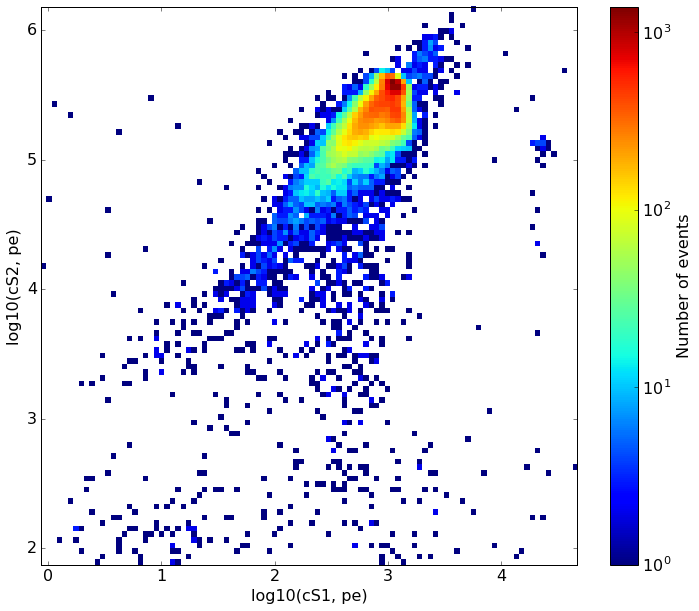

In [4]:
# Require a proper S1
data = data[data['cs1'] > 0]

# Make an S1 vs S2 histogram
plt.hist2d(np.log10(data['cs1']), np.log10(data['cs2']),
           bins=100, 
           norm=matplotlib.colors.LogNorm()   # Logarithmic color scale
)
plt.colorbar(label='Number of events')
plt.xlabel('log10(cS1, pe)')
plt.ylabel('log10(cS2, pe)')
plt.show()

## Getting your own data

Naturally, this basic data is rarely enough to do your work! Fortunately, extracting your own data is easy. You write a small TreeMaker class defining just one function: `extract_data`. This takes an `event` (the pax/ROOT object documented [here](http://xenon1t.github.io/pax/format.html)) and returns a dictionary with the data you want to save for that event. 

(It's ok if the dictionary is not the same for every event, missing values will become NaNs).

For example, suppose your are interested in the widths of the main S1 and S2. You can set up your TreeMaker like so:

In [5]:
class PeakWidthInfo(hax.minitrees.TreeMaker):
    # Activate the required branch while reading in the ROOT file
    # If you're too lazy to specify this, just put '*', but your TreeMaker will run slow!
    extra_branches = ['peaks.hit_time_std']
    __version__ = '0.0.1'
    
    def extract_data(self, event):
        # If there are no interactions at all, we can't extract anything...
        if not len(event.interactions):
            return dict()
        
        # Get the main S1 and main S2
        s1 = event.peaks[event.interactions[0].s1]
        s2 = event.peaks[event.interactions[0].s2]
        
        return dict(s1_hit_time_std=s1.hit_time_std,
                    s2_hit_time_std=s2.hit_time_std)

Then you can read in data like this:

In [ ]:
data = hax.minitrees.load(dataset,
                          [PeakWidthInfo, 'Basics'])
data.head(5)

Found minitree at ./xe100_120102_1607_PeakWidthInfo.root
Found minitree at ./xe100_120102_1607_Basics.root


,index,s1_hit_time_std,s2_hit_time_std,index,cs1,cs2,drift_time,event_number,event_time,largest_coincidence,...,largest_other_s2,largest_unknown,largest_veto,s1,s1_area_fraction_top,s2,s2_area_fraction_top,x,y,z
0,0,81.478790,715.608398,0,916.721855,233095.542697,77120.234375,0,1325516844038932992,0,...,549.494324,0,6.506931,827.102417,0.192298,196383.640625,0.419083,8.903773,1.432076,-13.341801
1,1,55.303967,379.709473,1,1100.245879,283938.145444,109342.296875,1,1325516844082907904,0,...,116261.570312,0,10.097024,1306.408447,0.146258,222688.406250,0.321690,2.179245,-2.677358,-18.916218
2,2,NaN,NaN,2,NaN,NaN,NaN,2,1325516844085651968,0,...,19.139214,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,70.223686,1488.914307,3,988.946391,93634.488534,162622.250000,3,1325516844108172032,0,...,119.179947,0,0.000000,1688.595947,0.046278,65236.296875,0.532941,7.160378,-1.432076,-28.133650
4,4,23.072817,389.816803,4,113.397541,61784.189470,1546.999023,4,1325516844113257984,0,...,67.338837,0,6.543261,69.385399,0.666641,61572.152344,0.646084,13.884906,4.669811,-0.267631


Notice s1_hit_time_std and s2_hit_time_std are now part of the dataframe. While you ran the above cell, a file `xe100_120402_2000_PeakWidthInfo.root` was created in the current directory. The next time you run the cell, the information is taken from this file (which is extremely fast) instead of rebuilt from scratch.

What if you change something in your TreeMaker? You can simply force load() to rebuild your tree:

In [ ]:
data = hax.minitrees.load(dataset,
                          PeakWidthInfo,
                          force_reload=True)

Found minitree at ./xe100_120102_1607_PeakWidthInfo.root
|##--------| 12691/46000  27% [elapsed: 00:19 left: 00:50, 653.31 iters/sec]

A gentler approach is to simply increment the version number of your TreeMaker.minitrees.load() will notice the minitrees are outdated and rebuild them. (try it!)

# Looping over ROOT files

If you don't like writing your own TreeMaker, or you just want to be 'closer to the ground', you can always just loop over each of the events in the ROOT files themselves. This takes just a few lines of code to setup (look up filename, get TFile, get tree, loop over entries, ....) but hax can save you this small trouble too.

If you define a function, hax will take care of executing it over all events in (one or more) datasets:

In [ ]:
help(hax.looproot.loop_over_dataset)

The 'event' your function gets is a pax/ROOT Event object documented [here](http://xenon1t.github.io/pax/format.html#event).

Here is a small (and silly!) example that counts how many events have more than 4 S1s:

In [ ]:
counter = 0

def count_many_s1s(event):
    global counter   # Need this in pyton to modify variable outside of function
    if len(event.s1s) > 4:
        counter += 1

hax.looproot.loop_over_datasets(['xe100_110228_1427', 'xe100_110302_1945'], count_many_s1s)
print("We found %d events with more than 4 S1s" % counter)

Another silly example: find the first event whose main s1 area is 70 pe in some dark matter dataset:

In [ ]:
def find_s1_70pe(event):
    if not len(event.interactions):
        # Continues to the next event
        # We're in a function, so need to do return rather than continue
        return
    main_interaction = event.interactions[0]
    main_s1 = event.peaks[main_interaction.s1]
    if np.round(main_s1.area) == 70:
        print("Event %s has a main S1 with area %s pe" % (event.event_number, main_s1.area))
        raise hax.looproot.StopEventLoop    # Special magic that aborts the loop immediately

hax.looproot.loop_over_dataset('xe100_120401_2201', find_s1_70pe)

# Selecting datasets

For any real analysis you'll want to select several datasets. In the future, hax will interface with the XENON1T run db for you. For now, it just loads some XENON100 runs info, and makes it available as a [pandas dataframe](http://pandas.pydata.org/pandas-docs/stable/10min.html) hax.runs.DATASETS.

(Internally this loads a CSV file, which is copy-pasted from the wiki's runs database table. For now I've only done run 10. Of course for XENON1T we don't want a static csv file, but a connection to the real runs database.)

Here's an example to get all standard AmBe datasets. Since DATASETS is a pandas DataFrame, you can use the 'query' method:

In [ ]:
hax.runs.DATASETS.query('source == "AmBe" & category == "standard" & tpc == "xenon100"')['name'].values

For more details on a particular dataset, use

In [ ]:
hax.runs.get_dataset_info('xe100_120401_2201')